In [146]:
import numpy as np # Linear Algebra
import pandas as pd # data processing

import os 
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

data\AIS_UNACORN.csv
data\data.csv
data\ObservationsAboutData.md


#### The Main Aim of this project is to handle a basic classification problem.
Can we predict the type of ship in a particular region by looking at its characteristics such as width, length, and values such as course and speed? 
* The dataset is derived from (DMA) Denmark Maritime Authority’s (open source) AIS information.
* Region - Kattegat Strait
* Date - Between 1 Jan 2022 to 10 Mar 2022


In [147]:
! pip install lightgbm

You should consider upgrading via the 'c:\users\eshan jairath\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [148]:
# importing the important Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

print('All the Libraries have been imported !!')

All the Libraries have been imported !!


In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import pandas as pd
from sklearn.metrics import accuracy_score


print(" All the models Imported ")

 All the models Imported 


In [150]:
# Slight Adjustments to the screen settings

from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns',None)
pd.set_option('display.width',500)
pd.set_option('display.float_format',lambda x: f'{x:.4f}')

In [151]:
# Loading the data

df= pd.read_csv('./data/data.csv')
df.head()

# print('Dataset Loaded !!')

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
0,0,219019621,Unknown value,0.0000,86.0000,86.0000,Fishing,4.0000,9.0000,NaN
1,1,265628170,Unknown value,0.0000,334.5000,NaN,Port tender,8.0000,27.0000,NaN
2,2,219005719,Unknown value,0.0000,208.7000,NaN,Fishing,4.0000,11.0000,NaN
3,3,219028066,Unknown value,0.0000,NaN,NaN,Pleasure,3.0000,12.0000,NaN
4,4,212584000,Moored,0.0000,153.0000,106.0000,Cargo,13.0000,99.0000,6.3000


In [152]:
df.shape

(358351, 10)

In [153]:
# Let's Remove the unwanted Columns
df.drop(['Unnamed: 0'], axis=1, inplace= True)  

In [154]:
# Let's look at the null values
df.isnull().sum() 

mmsi                      0
navigationalstatus        0
sog                     458
cog                    3169
heading               20614
shiptype                  0
width                  3711
length                 3743
draught               25543
dtype: int64

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358351 entries, 0 to 358350
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   mmsi                358351 non-null  int64  
 1   navigationalstatus  358351 non-null  object 
 2   sog                 357893 non-null  float64
 3   cog                 355182 non-null  float64
 4   heading             337737 non-null  float64
 5   shiptype            358351 non-null  object 
 6   width               354640 non-null  float64
 7   length              354608 non-null  float64
 8   draught             332808 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 24.6+ MB


In [156]:
# lets do the Exploratory data analysis
# cat_th is short for "categorical threshold" 
# car_th is short for "cardinality threshold"



def grab_col_names(dataframe, cat_th = 10, car_th=20):
    #cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes =="O"] #Object data type
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes !="O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in  cat_but_car]

    #num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations : {dataframe.shape[0]}")
    print(f"Variables :{dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car



In [157]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations : 358351
Variables :9
cat_cols: 2
num_cols: 7
cat_but_car: 0
num_but_cat: 0


At sea, every vessel propagates the info regularly.
Lets see out of 358351 observations how many vessel numbers we have. 

In [158]:
df.groupby('mmsi').count().shape

(3894, 8)

In [159]:
df['mmsi'].value_counts()

219945000    1961
266343000    1773
266331000    1765
265859000    1532
209536000    1478
             ... 
219019917       1
219018499       1
259075000       1
219022542       1
219024472       1
Name: mmsi, Length: 3894, dtype: int64

In [160]:
df['navigationalstatus'].value_counts()

Under way using engine                                   307581
Unknown value                                             17259
Constrained by her draught                                12287
Engaged in fishing                                        10798
Moored                                                     4121
Reserved for future amendment [HSC]                        1872
Restricted maneuverability                                 1868
Under way sailing                                          1396
At anchor                                                   513
Power-driven vessel towing astern                           377
Power-driven vessel pushing ahead or towing alongside       236
Not under command                                            31
Reserved for future amendment [WIG]                          12
Name: navigationalstatus, dtype: int64

In [161]:
# lets see the number of missing values in the dataset

def missing_values_table(data):
    m = data.isnull().sum()
    print(pd.DataFrame({'n_miss' : m[m!=0], 'ratio' : m[m!=0]/len(data)}))

missing_values_table(df)

         n_miss  ratio
sog         458 0.0013
cog        3169 0.0088
heading   20614 0.0575
width      3711 0.0104
length     3743 0.0104
draught   25543 0.0713


As, we can see the draught and heading column has the most no. of missing values 

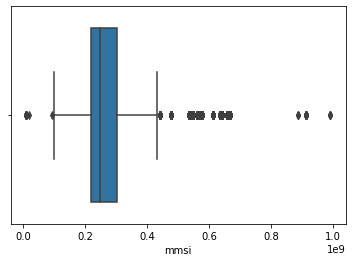


 Number of outliers for mmsi : 24


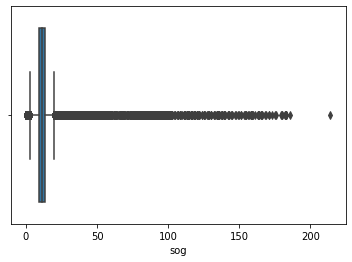


 Number of outliers for sog : 2910


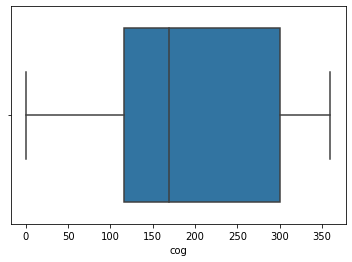

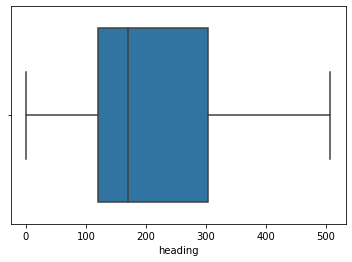

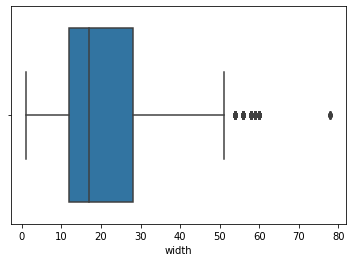


 Number of outliers for width : 9


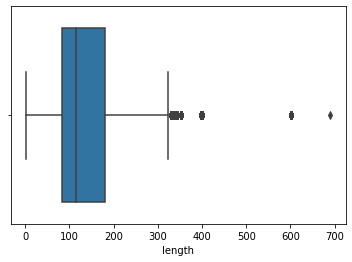


 Number of outliers for length : 47


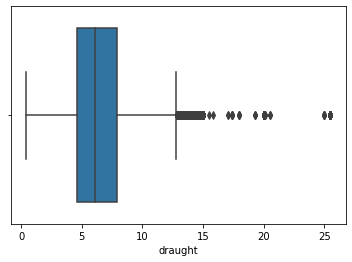


 Number of outliers for draught : 567


In [162]:
def thresholds(col, data, d, u):
    q3 = data[col].quantile(u)
    q1 = data[col].quantile(d)
    down = q1-(q3-q1)*1.5
    up = q1+(q3-q1)*1.5
    return down, up 

def check_outliers(col, data, d=0.25, u = 0.75, plot = True):
    down, up = thresholds(col,data,d,u)
    ind = data[(data[col] < down) | (data[col] > up )].index
    if plot:
        sns.boxplot(x=col, data = data)
        plt.show()
    if len(ind)!=0:
        print(f"\n Number of outliers for {col} : {len(ind)}")
        return col
    
for col in num_cols:
    check_outliers(col, df, 0.01, 0.99)



heading  cog     0.9617
length   width   0.9564
dtype: float64


[('heading', 'cog'), ('length', 'width')]

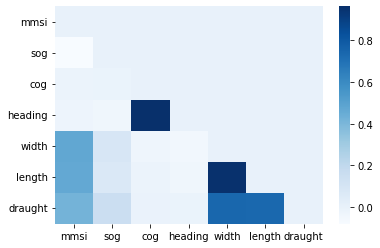

In [163]:
#Correlations between variables 

def corr_analyzer(data, corr_th=0.7, plot = False):
    corr_matrix = pd.DataFrame(np.tril(data.corr(), k=-1), columns=data.corr().columns, index= data.corr().columns)
    corr = corr_matrix[corr_matrix > corr_th].stack()
    print(corr)

    if plot:
        sns.heatmap(corr_matrix, cmap='Blues')
    return corr[corr>corr_th].index.to_list()

corr_analyzer(df, corr_th=0.75, plot=True)

Actually ‘cog’ and ‘heading’ variables are very similar. Also, there is a high correlation between them. So we can combine these two as one.

In [164]:
# First, the filling was made according to those in the 'heading' but not in the 'cog'. So we have fewer missings at 'cog'

df['route'] = np.where(df['cog'].isnull(), df['heading'], df['cog']) 

# Secondly, we divided the 360-degree route into 8 regions.
rot= [-1, 45, 90, 135, 180, 225, 270, 315, 360]
df['waypoint'] = pd.cut(df['route'], rot, labels=['NNE','ENE','ESE','SSE','SSW','WSW','WNW','NNW'])

# Finally, the ships with less than 5.5kts speed and no route information were tagged as 'FIX'.
df['waypoint'] = np.where((df['sog']<5.5) & (df['waypoint'].isnull()), 'FIX', df['waypoint'])
df.head()

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,route,waypoint
0,219019621,Unknown value,0.0000,86.0000,86.0000,Fishing,4.0000,9.0000,NaN,86.0000,ENE
1,265628170,Unknown value,0.0000,334.5000,NaN,Port tender,8.0000,27.0000,NaN,334.5000,NNW
2,219005719,Unknown value,0.0000,208.7000,NaN,Fishing,4.0000,11.0000,NaN,208.7000,SSW
3,219028066,Unknown value,0.0000,NaN,NaN,Pleasure,3.0000,12.0000,NaN,NaN,FIX
4,212584000,Moored,0.0000,153.0000,106.0000,Cargo,13.0000,99.0000,6.3000,153.0000,SSE


Vessels’ speed depends on ship type mostly. We fill the missings according to 'sog' and 'route' variables. Then assigned as a new variable

In [165]:
df['speed'] = df["sog"].fillna(df.groupby(['shiptype', 'waypoint'])['sog'].transform('mean'))
df.head()

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,route,waypoint,speed
0,219019621,Unknown value,0.0000,86.0000,86.0000,Fishing,4.0000,9.0000,NaN,86.0000,ENE,0.0000
1,265628170,Unknown value,0.0000,334.5000,NaN,Port tender,8.0000,27.0000,NaN,334.5000,NNW,0.0000
2,219005719,Unknown value,0.0000,208.7000,NaN,Fishing,4.0000,11.0000,NaN,208.7000,SSW,0.0000
3,219028066,Unknown value,0.0000,NaN,NaN,Pleasure,3.0000,12.0000,NaN,NaN,FIX,0.0000
4,212584000,Moored,0.0000,153.0000,106.0000,Cargo,13.0000,99.0000,6.3000,153.0000,SSE,0.0000


New aspect for the dimensions;

In [166]:
df['dimension'] = df['width'] * df['length']
df.head()

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught,route,waypoint,speed,dimension
0,219019621,Unknown value,0.0000,86.0000,86.0000,Fishing,4.0000,9.0000,NaN,86.0000,ENE,0.0000,36.0000
1,265628170,Unknown value,0.0000,334.5000,NaN,Port tender,8.0000,27.0000,NaN,334.5000,NNW,0.0000,216.0000
2,219005719,Unknown value,0.0000,208.7000,NaN,Fishing,4.0000,11.0000,NaN,208.7000,SSW,0.0000,44.0000
3,219028066,Unknown value,0.0000,NaN,NaN,Pleasure,3.0000,12.0000,NaN,NaN,FIX,0.0000,36.0000
4,212584000,Moored,0.0000,153.0000,106.0000,Cargo,13.0000,99.0000,6.3000,153.0000,SSE,0.0000,1287.0000


After dropping the duplicates we have a total of 3894 ships. Let’s have a look at the final form of output.

In [167]:
df = df.drop_duplicates(subset='mmsi') # one vessel has more than one data
df.groupby(['shiptype'])['mmsi'].count()

shiptype
Cargo               1716
Dredging              53
Fishing              325
HSC                   27
Law enforcement       20
Military              79
Passenger            123
Pilot                 41
Pleasure             414
Port tender           12
Reserved              12
SAR                  123
Sailing              215
Tanker               642
Towing                11
Towing long/wide       3
Tug                   78
Name: mmsi, dtype: int64

In [168]:
# no need anymore
df.drop(['cog', 'heading', 'route', 'sog', 'mmsi'], axis=1, inplace=True) 

In [169]:
df.head()

,navigationalstatus,shiptype,width,length,draught,waypoint,speed,dimension
0,Unknown value,Fishing,4.0000,9.0000,NaN,ENE,0.0000,36.0000
1,Unknown value,Port tender,8.0000,27.0000,NaN,NNW,0.0000,216.0000
2,Unknown value,Fishing,4.0000,11.0000,NaN,SSW,0.0000,44.0000
3,Unknown value,Pleasure,3.0000,12.0000,NaN,FIX,0.0000,36.0000
4,Moored,Cargo,13.0000,99.0000,6.3000,SSE,0.0000,1287.0000


### Encoding

In [170]:
# taking account for the new variables
cat_cols, num_cols, cat_but_car = grab_col_names(df) 

Observations : 3894
Variables :8
cat_cols: 3
num_cols: 5
cat_but_car: 0
num_but_cat: 0


In [171]:
def cat_summary(dataframe, col_name, plot = False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(), "Ratio" : 100*dataframe[col_name].value_counts() / len(dataframe)}))

    print(" ")
    print(" _____________________________________________________ ")
    print(" ")

    if plot:
        sns.countplot(x=dataframe[col_name], data = dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df,col)


                                                    navigationalstatus   Ratio
Under way using engine                                            2587 66.4355
Unknown value                                                      926 23.7802
Moored                                                             130  3.3385
Engaged in fishing                                                 100  2.5681
Constrained by her draught                                          81  2.0801
Restricted maneuverability                                          21  0.5393
At anchor                                                           20  0.5136
Under way sailing                                                   17  0.4366
Reserved for future amendment [HSC]                                  5  0.1284
Not under command                                                    3  0.0770
Power-driven vessel towing astern                                    2  0.0514
Reserved for future amendment [WIG]                 

In our Dataset, there are rare values in categorical variables. We group these classes if they are lower than 2%.

In [172]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O' and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis = None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    
    return temp_df

df = rare_encoder(df, 0.02)


In [173]:
df.head()

,navigationalstatus,shiptype,width,length,draught,waypoint,speed,dimension
0,Unknown value,Fishing,4.0000,9.0000,NaN,ENE,0.0000,36.0000
1,Unknown value,Rare,8.0000,27.0000,NaN,NNW,0.0000,216.0000
2,Unknown value,Fishing,4.0000,11.0000,NaN,SSW,0.0000,44.0000
3,Unknown value,Pleasure,3.0000,12.0000,NaN,FIX,0.0000,36.0000
4,Moored,Cargo,13.0000,99.0000,6.3000,SSE,0.0000,1287.0000


In [174]:
# combining the 'Unknown value' and 'Rare' groups at 'navigationalstatus' variable
df['status'] = df['navigationalstatus'].where(
    ~((df['navigationalstatus']=='Unknown value') | (df['navigationalstatus']=='Rare')), 'Other') 

In [175]:
df.head()

,navigationalstatus,shiptype,width,length,draught,waypoint,speed,dimension,status
0,Unknown value,Fishing,4.0000,9.0000,NaN,ENE,0.0000,36.0000,Other
1,Unknown value,Rare,8.0000,27.0000,NaN,NNW,0.0000,216.0000,Other
2,Unknown value,Fishing,4.0000,11.0000,NaN,SSW,0.0000,44.0000,Other
3,Unknown value,Pleasure,3.0000,12.0000,NaN,FIX,0.0000,36.0000,Other
4,Moored,Cargo,13.0000,99.0000,6.3000,SSE,0.0000,1287.0000,Moored


As we are using the status variable therefore we will discard the ‘navigationalstatus’ variable. Also there is high corrrelations between ‘dimension’, ‘width’ and ‘length’. So we will disregard ‘width’ and ‘length’ variables.

In [176]:
df.drop(['navigationalstatus', 'width', 'length'], axis=1, inplace=True)
df.head()

,shiptype,draught,waypoint,speed,dimension,status
0,Fishing,NaN,ENE,0.0000,36.0000,Other
1,Rare,NaN,NNW,0.0000,216.0000,Other
2,Fishing,NaN,SSW,0.0000,44.0000,Other
3,Pleasure,NaN,FIX,0.0000,36.0000,Other
4,Cargo,6.3000,SSE,0.0000,1287.0000,Moored


In [177]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations : 3894
Variables :6
cat_cols: 3
num_cols: 3
cat_but_car: 0
num_but_cat: 0


In [178]:
# with rare class
for col in cat_cols:
    cat_summary(df, col)

           shiptype   Ratio
Cargo          1716 44.0678
Tanker          642 16.4869
Pleasure        414 10.6317
Fishing         325  8.3462
Sailing         215  5.5213
Rare            179  4.5968
SAR             123  3.1587
Passenger       123  3.1587
Military         79  2.0288
Tug              78  2.0031
 
 _____________________________________________________ 
 
     waypoint   Ratio
SSE       688 17.6682
NNW       659 16.9235
ESE       616 15.8192
NNE       612 15.7165
ENE       485 12.4551
SSW       307  7.8839
FIX       243  6.2404
WSW       166  4.2630
WNW       115  2.9533
 
 _____________________________________________________ 
 
                            status   Ratio
Under way using engine        2587 66.4355
Other                          996 25.5778
Moored                         130  3.3385
Engaged in fishing             100  2.5681
Constrained by her draught      81  2.0801
 
 _____________________________________________________ 
 


In [179]:
# Splitting data as an output and predictors;
y = df['shiptype']
X= df.drop('shiptype', axis=1)

In [180]:
# One hot encoding 

def one_hot_encode(dataframe, categorical_cols, drop_first = True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

X = one_hot_encode(X, ['waypoint', 'status'])
X.head(3)

,draught,speed,dimension,waypoint_ESE,waypoint_FIX,waypoint_NNE,waypoint_NNW,waypoint_SSE,waypoint_SSW,waypoint_WNW,waypoint_WSW,status_Engaged in fishing,status_Moored,status_Other,status_Under way using engine
0,NaN,0.0000,36.0000,0,0,0,0,0,0,0,0,0,0,1,0
1,NaN,0.0000,216.0000,0,0,0,1,0,0,0,0,0,0,1,0
2,NaN,0.0000,44.0000,0,0,0,0,0,1,0,0,0,0,1,0


For the Scaling process we will use the Robust Scaler as it has better results to outliers

In [181]:
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,draught,speed,dimension,waypoint_ESE,waypoint_FIX,waypoint_NNE,waypoint_NNW,waypoint_SSE,waypoint_SSW,waypoint_WNW,waypoint_WSW,status_Engaged in fishing,status_Moored,status_Other,status_Under way using engine
0,NaN,-1.6349,-0.2872,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,-1.0000
1,NaN,-1.6349,-0.2478,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,-1.0000
2,NaN,-1.6349,-0.2854,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,-1.0000
3,NaN,-1.6349,-0.2872,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,-1.0000
4,0.0000,-1.6349,-0.0138,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,-1.0000


In [182]:
missing_values_table(df)

           n_miss  ratio
draught      1017 0.2612
waypoint        3 0.0008
speed           3 0.0008
dimension     123 0.0316


## Modelling

We will use LightGBM, as it's Quick and Accurate and ther is also no need to drop missing as lightGBM is usefull in that case as well.

In [197]:
# Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [184]:
# lets see our training data 
print('Training data shape => ',X_train.shape)
print('Testing data shape => ', X_test.shape)

Training data shape =>  (2725, 15)
Testing data shape =>  (1169, 15)


In [185]:
lgbm = LGBMClassifier(random_state=17)
lgbm

LGBMClassifier(random_state=17)

In [186]:
# defining the hyper-parameters for lgbm 

lgbm_params = {'max_depth': [2,5,8,10],
               'learning_rate':[0.001,0.01,0.05,0.1],
               'n_estimators':[200, 400, 600, 900],
                'colsample_bytree':[0.3, 0.5, 0.7, 1]}

lgbm_cv = GridSearchCV(lgbm, lgbm_params, cv=10, n_jobs=-1, verbose=True)
lgbm_cv.fit(X,y) 

Fitting 10 folds for each of 256 candidates, totalling 2560 fits


GridSearchCV(cv=10, estimator=LGBMClassifier(random_state=17), n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7, 1],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1],
                         'max_depth': [2, 5, 8, 10],
                         'n_estimators': [200, 400, 600, 900]},
             verbose=True)

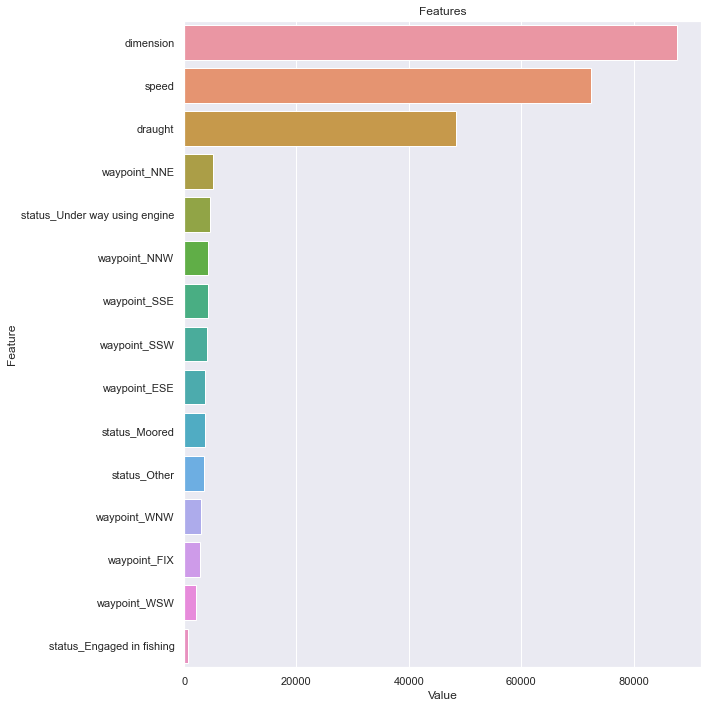

In [201]:
def plot_importance(model, features, num = len(X)):
    feature_imp = pd.DataFrame({'Value' : model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x = 'Value', y = 'Feature', data = feature_imp.sort_values(by='Value', ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()


lgbm_f = lgbm.set_params(**lgbm_cv.best_params_, random_state=17).fit(X_train,y_train)
plot_importance(lgbm_f, X_train)

In [202]:
lgbm_final = lgbm.set_params(**lgbm_cv.best_params_, random_state=17)
lgbm_results = cross_val_score(lgbm_final, X_test, y_test, cv =10, scoring="accuracy").mean()
lgbm_results

0.6621500147362217

In [203]:
from sklearn.impute import SimpleImputer

# Create an imputer object with median strategy
imputer = SimpleImputer(strategy='median')

# Fit the imputer on X_train
imputer.fit(X_train)

# Transform X_train and X_test using the trained imputer
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Now the input data should be free of NaN or infinity values


The Accuracy is around 68% this score is nice for multiclass prediction 


In [291]:

def superClassifier(acc_df = False, class_report = False, obs = False ):
    models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "SVC": SVC(),
    "KNeighbors Classifier": KNeighborsClassifier(),
    }
    
    print('All the Classification Models Loaded !!')
    print('_'*100)
    accuracies = {}
    print('Starting the Training of the Models...')
    for name, model in models.items():
        print(' ')
        print("Model training on : ", name)
        model.fit(X_train,y_train) 
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred)
        print(f"{name} model training complete...")
        accuracy = accuracy_score(y_test,y_pred)
        accuracies[name] = accuracy
        print(f"Accuracy: {accuracies[name]}")
        print(" ")

        if class_report == True:
            print("The Entire Classification report of ", name)
            print(report)
            print('_'*100)
            print(' ')
        
        if obs:
            print("Pie Chart showing Predicted labels of {} Model".format(name))
            pred_counts = pd.Series(y_pred).value_counts()
            plt.pie(pred_counts, labels= pred_counts.index, autopct='%1.2f%%')
            plt.title('Predicted Labels')
            plt.show()
            print('_'*100)

    if acc_df == True:
        df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy'])
        df.sort_values(by='Accuracy', ascending=False, inplace=True)
        print(f'Models with their accuracy in decreasing order -:')
        print('_'*100)
        print(df)
        print('_'*100)
    
    max_accuracy = max(accuracies.values())
    print("Best performing model(s):")
    for model, accuracy in accuracies.items():
        if accuracy == max_accuracy:
            print(f"{model}: {accuracy}")    

All the Classification Models Loaded !!
____________________________________________________________________________________________________
Starting the Training of the Models...
 
Model training on :  Logistic Regression
Logistic Regression model training complete...
Accuracy: 0.5372112917023096
 
The Entire Classification report of  Logistic Regression
              precision    recall  f1-score   support

       Cargo       0.62      0.93      0.74       484
     Fishing       0.57      0.31      0.40        95
    Military       0.20      0.14      0.17        21
   Passenger       0.12      0.03      0.04        40
    Pleasure       0.40      0.86      0.55       129
        Rare       0.41      0.17      0.24        63
         SAR       0.29      0.16      0.20        38
     Sailing       0.00      0.00      0.00        68
      Tanker       0.44      0.09      0.15       206
         Tug       0.00      0.00      0.00        25

    accuracy                           0.54   

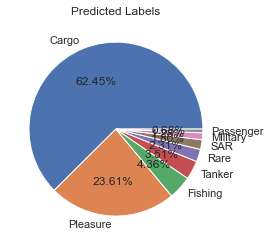

____________________________________________________________________________________________________
 
Model training on :  Decision Tree Classifier
Decision Tree Classifier model training complete...
Accuracy: 0.6253207869974337
 
The Entire Classification report of  Decision Tree Classifier
              precision    recall  f1-score   support

       Cargo       0.79      0.82      0.80       484
     Fishing       0.48      0.52      0.49        95
    Military       0.36      0.38      0.37        21
   Passenger       0.33      0.35      0.34        40
    Pleasure       0.47      0.53      0.50       129
        Rare       0.37      0.35      0.36        63
         SAR       0.44      0.39      0.42        38
     Sailing       0.36      0.24      0.29        68
      Tanker       0.68      0.63      0.66       206
         Tug       0.50      0.48      0.49        25

    accuracy                           0.63      1169
   macro avg       0.48      0.47      0.47      1169
we

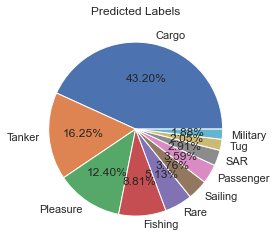

____________________________________________________________________________________________________
 
Model training on :  Random Forest Classifier
Random Forest Classifier model training complete...
Accuracy: 0.6390076988879384
 
The Entire Classification report of  Random Forest Classifier
              precision    recall  f1-score   support

       Cargo       0.76      0.92      0.83       484
     Fishing       0.53      0.59      0.56        95
    Military       0.32      0.29      0.30        21
   Passenger       0.38      0.20      0.26        40
    Pleasure       0.43      0.50      0.46       129
        Rare       0.41      0.35      0.38        63
         SAR       0.38      0.37      0.37        38
     Sailing       0.32      0.25      0.28        68
      Tanker       0.82      0.51      0.63       206
         Tug       0.67      0.40      0.50        25

    accuracy                           0.64      1169
   macro avg       0.50      0.44      0.46      1169
we

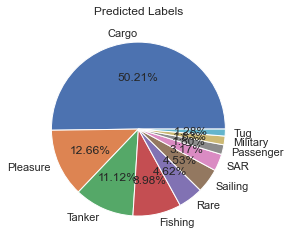

____________________________________________________________________________________________________
 
Model training on :  SVC
SVC model training complete...
Accuracy: 0.5842600513259196
 
The Entire Classification report of  SVC
              precision    recall  f1-score   support

       Cargo       0.65      0.95      0.77       484
     Fishing       0.66      0.28      0.40        95
    Military       0.18      0.19      0.19        21
   Passenger       0.00      0.00      0.00        40
    Pleasure       0.40      0.91      0.55       129
        Rare       0.62      0.25      0.36        63
         SAR       0.45      0.13      0.20        38
     Sailing       0.00      0.00      0.00        68
      Tanker       0.83      0.25      0.39       206
         Tug       0.00      0.00      0.00        25

    accuracy                           0.58      1169
   macro avg       0.38      0.30      0.29      1169
weighted avg       0.56      0.58      0.51      1169

__________

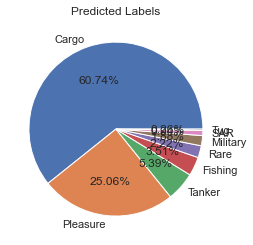

____________________________________________________________________________________________________
 
Model training on :  KNeighbors Classifier
KNeighbors Classifier model training complete...
Accuracy: 0.58169375534645
 
The Entire Classification report of  KNeighbors Classifier
              precision    recall  f1-score   support

       Cargo       0.70      0.89      0.78       484
     Fishing       0.49      0.47      0.48        95
    Military       0.20      0.14      0.17        21
   Passenger       0.33      0.10      0.15        40
    Pleasure       0.38      0.56      0.45       129
        Rare       0.41      0.21      0.27        63
         SAR       0.29      0.11      0.15        38
     Sailing       0.17      0.12      0.14        68
      Tanker       0.70      0.50      0.58       206
         Tug       0.00      0.00      0.00        25

    accuracy                           0.58      1169
   macro avg       0.37      0.31      0.32      1169
weighted avg 

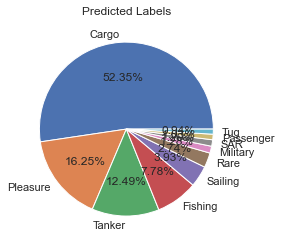

____________________________________________________________________________________________________
Models with their accuracy in decreasing order -:
____________________________________________________________________________________________________
                          Accuracy
Random Forest Classifier    0.6390
Decision Tree Classifier    0.6253
SVC                         0.5843
KNeighbors Classifier       0.5817
Logistic Regression         0.5372
____________________________________________________________________________________________________
Best performing model(s):
Random Forest Classifier: 0.6390076988879384


In [292]:
superClassifier(obs=True, acc_df=True, class_report=True)

## Feature Importance

In [205]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy :", accuracy)


Accuracy : 0.660393498716852


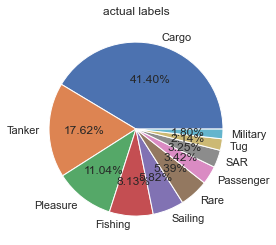

In [206]:
# Pie chart of acutal values 
actual_counts = y_test.value_counts()
plt.pie(actual_counts, labels=actual_counts.index, autopct='%1.2f%%')
plt.title('actual labels')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

# create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(set(y)))
plt.xticks(tick_marks, set(y), rotation=90)
plt.yticks(tick_marks, set(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
random_ship = X.sample(1)
random_ship

In [ ]:
def estimator(sample):
    
    print(f"Actual ship type \t : {lgbm_final.predict(random_ship)[0]}")
    temp = y.reset_index()
    print(f" Predicted Ship type \t : {temp[temp.index == sample.index[0]].iloc[0,1]} ")

In [ ]:
print (estimator(random_ship))